In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
from imblearn.over_sampling import RandomOverSampler
from transformers import pipeline

In [15]:
# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("comments.csv")   # dataset (expects "Comments" column)
df = df.dropna(subset=["Comments"])  # drop empty rows

print("Sample data:\n", df.head())

Sample data:
                                             Comments
0  bat walang gumagalaw Kay Romualdez eh siya nga...
1                               kunyari hindi alam..
2  question before mag release nang full payment ...
3              di ako naniniwala na di nila alam yan
4          Sana kampi ka sa kabutihan Vince Dizon 🙏🙏


In [16]:
# ==============================
# 2. Generate Pseudo-Labels with Reliability Filtering
# ==============================
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def get_sentiment_with_score(text):
    try:
        r = sentiment_model(str(text))[0]
        return r['label'].lower(), r['score']
    except:
        return "neutral", 0.0

tmp = df['Comments'].apply(
    lambda t: pd.Series(get_sentiment_with_score(t), index=['Sentiment','Score'])
)
df = pd.concat([df, tmp], axis=1)

# Keep only positive/negative with confidence >= 0.6
df = df[(df["Sentiment"].isin(["positive", "negative"])) & (df["Score"] >= 0.6)]

print("\nSentiment distribution after filtering:\n", df["Sentiment"].value_counts())

Device set to use cuda:0



Sentiment distribution after filtering:
 Sentiment
negative    794
positive    164
Name: count, dtype: int64


In [18]:
# ==============================
# 3. Train-Test-Unseen Split (70/20/10)
# ==============================
# Step 1: Hold out 10% unseen
rest_df, unseen_df = train_test_split(
    df, test_size=0.10, stratify=df['Sentiment'], random_state=42
)
# Step 2: From remaining 90%, split 70/20 (relative: 70/90 ≈ 77.8%)
train_df, test_df = train_test_split(
    rest_df, test_size=2/9, stratify=rest_df['Sentiment'], random_state=42
)

print(f"\nTrain: {len(train_df)}, Test: {len(test_df)}, Unseen: {len(unseen_df)}")


Train: 670, Test: 192, Unseen: 96


In [19]:
# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['Comments'])
y_train = train_df['Sentiment']
X_test = vectorizer.transform(test_df['Comments'])
y_test = test_df['Sentiment']
X_unseen = vectorizer.transform(unseen_df['Comments'])
y_unseen = unseen_df['Sentiment']

In [20]:
# ==============================
# 5. Apply RandomOverSampler (fixes SMOTE issue with sparse)
# ==============================
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("\nBalanced training distribution:\n", pd.Series(y_train_bal).value_counts())


Balanced training distribution:
 Sentiment
positive    555
negative    555
Name: count, dtype: int64



===== Naive Bayes =====
Accuracy (Test): 0.7604
              precision    recall  f1-score   support

    negative       0.91      0.79      0.84       159
    positive       0.38      0.64      0.48        33

    accuracy                           0.76       192
   macro avg       0.65      0.71      0.66       192
weighted avg       0.82      0.76      0.78       192



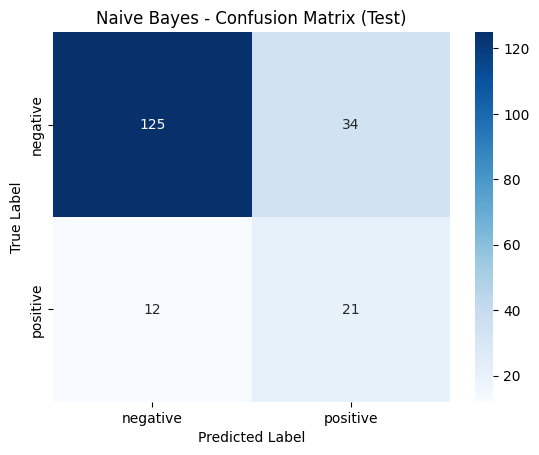


===== Logistic Regression =====
Accuracy (Test): 0.7917
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87       159
    positive       0.41      0.45      0.43        33

    accuracy                           0.79       192
   macro avg       0.64      0.66      0.65       192
weighted avg       0.80      0.79      0.80       192



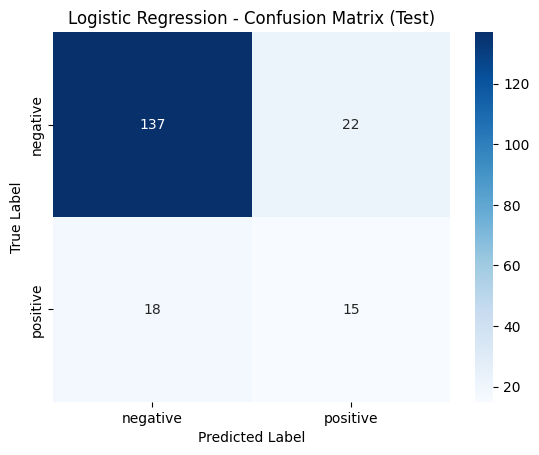


Best Logistic Regression params: {'C': 10}


In [22]:
# ==============================
# 6. Train Models (with Iterative Improvement for LR)
# ==============================
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy (Test): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {"model": model, "test_acc": acc}

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"]
    )
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Iterative Improvement: Hyperparameter tuning for Logistic Regression
param_grid = {"C": [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    param_grid, cv=3, scoring="f1_macro"
)
grid.fit(X_train_bal, y_train_bal)
print("\nBest Logistic Regression params:", grid.best_params_)
best_lr = grid.best_estimator_

# Update results with best LR
results["Logistic Regression (Tuned)"] = {
    "model": best_lr,
    "test_acc": accuracy_score(y_test, best_lr.predict(X_test))
}


===== Final Evaluation on Unseen Data (Naive Bayes) =====
Accuracy (Unseen): 0.8125
              precision    recall  f1-score   support

    negative       0.92      0.85      0.88        80
    positive       0.45      0.62      0.53        16

    accuracy                           0.81        96
   macro avg       0.69      0.74      0.70        96
weighted avg       0.84      0.81      0.82        96



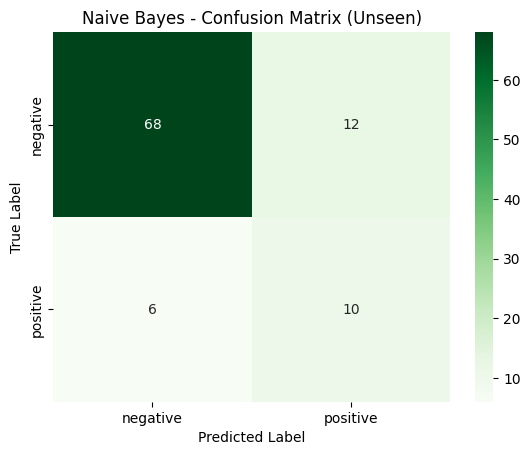


===== Final Evaluation on Unseen Data (Logistic Regression) =====
Accuracy (Unseen): 0.8333
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90        80
    positive       0.50      0.44      0.47        16

    accuracy                           0.83        96
   macro avg       0.70      0.68      0.68        96
weighted avg       0.83      0.83      0.83        96



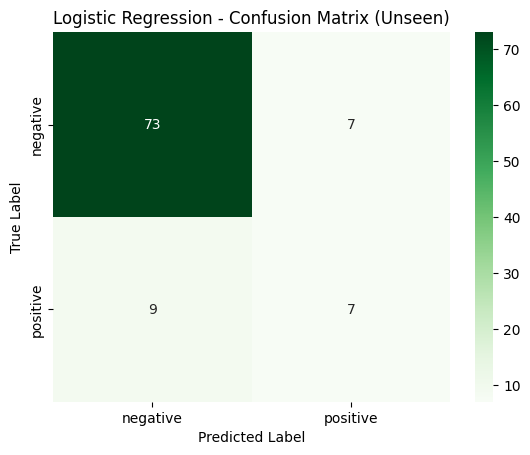


===== Final Evaluation on Unseen Data (Logistic Regression (Tuned)) =====
Accuracy (Unseen): 0.8646
              precision    recall  f1-score   support

    negative       0.89      0.95      0.92        80
    positive       0.64      0.44      0.52        16

    accuracy                           0.86        96
   macro avg       0.77      0.69      0.72        96
weighted avg       0.85      0.86      0.85        96



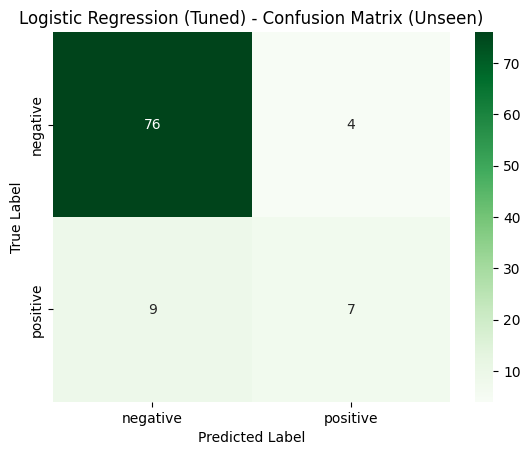

In [23]:
# ==============================
# 7. Evaluate on Unseen Data
# ==============================
for name, res in results.items():
    print(f"\n===== Final Evaluation on Unseen Data ({name}) =====")
    model = res["model"]
    y_pred_unseen = model.predict(X_unseen)
    acc_unseen = accuracy_score(y_unseen, y_pred_unseen)
    print(f"Accuracy (Unseen): {acc_unseen:.4f}")
    print(classification_report(y_unseen, y_pred_unseen))

    cm = confusion_matrix(y_unseen, y_pred_unseen, labels=["negative", "positive"])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"]
    )
    plt.title(f"{name} - Confusion Matrix (Unseen)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [24]:
# ==============================
# 9. Additional Analysis
# ==============================
print("\n===== ADDITIONAL ANALYSIS =====")
for name, res in results.items():
    model = res['model']
    y_pred = model.predict(X_test)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='positive')
    print(f"{name} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}")

# Error analysis: show sample false positives/negatives
test_df = test_df.copy()
test_df["Pred"] = best_model.predict(X_test)
fn = test_df[(test_df['Sentiment']=='positive') & (test_df['Pred']=='negative')].head(5)
fp = test_df[(test_df['Sentiment']=='negative') & (test_df['Pred']=='positive')].head(5)

print("\nSAMPLE FALSE NEGATIVES:\n", fn['Comments'].tolist())
print("\nSAMPLE FALSE POSITIVES:\n", fp['Comments'].tolist())


===== ADDITIONAL ANALYSIS =====
Naive Bayes -> Precision: 0.382, Recall: 0.636, F1: 0.477
Logistic Regression -> Precision: 0.405, Recall: 0.455, F1: 0.429
Logistic Regression (Tuned) -> Precision: 0.433, Recall: 0.394, F1: 0.413

SAMPLE FALSE NEGATIVES:
 ['Some of them are also leading the well scripted investigation', 'We would like to know who the members are of this group. 🇵🇭', "Ang sinungaling at ang magnanakaw ay kapatid ng kadiliman at kasamaan!\n\nFloods were getting everywhere amid climate crisis, not just the Philippines but the whole world itself. We Filipinos believe in our minds and our intelligence that this 51 billion budget for Davao City, Davao del Sur's flood control infrastructure was stolen and snatched by the Dutertes used for political gains, personal agendas and vicious Duterteism ideology that is anti-Filipino, anti-humanity and anti-democratic.", 'aquino nanaman ang nangunguna lmao', 'After 6 months all is gotten. Happy days are here again']

SAMPLE FALSE POSI

In [ ]:
# ==============================
# 10. Show Top Positive & Negative Comments (Top 10 each in Tables)
# ==============================
best_model = results["Logistic Regression (Tuned)"]["model"]
probs = best_model.predict_proba(X_unseen)

unseen_df["Prob_Negative"] = probs[:, 0]
unseen_df["Prob_Positive"] = probs[:, 1]

# Get top 10 for each
top_neg = unseen_df.sort_values(by="Prob_Negative", ascending=False).head(10)[["Comments", "Prob_Negative"]]
top_pos = unseen_df.sort_values(by="Prob_Positive", ascending=False).head(10)[["Comments", "Prob_Positive"]]

# Round probabilities for readability
top_neg["Prob_Negative"] = top_neg["Prob_Negative"].round(3)
top_pos["Prob_Positive"] = top_pos["Prob_Positive"].round(3)

# Rename columns for better display
top_neg_display = top_neg.rename(columns={"Prob_Negative": "Negative Probability"})
top_pos_display = top_pos.rename(columns={"Prob_Positive": "Positive Probability"})

# Reset index to start from 1
top_neg_display.reset_index(drop=True, inplace=True)
top_pos_display.reset_index(drop=True, inplace=True)
top_neg_display.index = range(1, len(top_neg_display) + 1)
top_pos_display.index = range(1, len(top_pos_display) + 1)

# ==============================
# Display as Excel-style Tables
# ==============================
print("\n" + "="*80)
print("TOP 10 MOST NEGATIVE COMMENTS")
print("="*80)

# Style the negative comments table
styled_neg = top_neg_display.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ffcccc'), ('color', 'black'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
]).format({'Negative Probability': '{:.3f}'})

display(styled_neg)

print("\n" + "="*80)
print("TOP 10 MOST POSITIVE COMMENTS")
print("="*80)

# Style the positive comments table
styled_pos = top_pos_display.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ccffcc'), ('color', 'black'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
]).format({'Positive Probability': '{:.3f}'})

display(styled_pos)